In [1]:
### Prepare module structure ###

import sys
sys.path.append("../")

In [2]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
import data
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

1.0.0


In [3]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:1


In [4]:
### LOAD DATA ###

dataset = 'mnist'
dataloader, imsize = data.load(dataset, path='../data/' + dataset, batch_size=256)

In [5]:
def calc_mags(x):
    ft =  torch.rfft(x, 2, onesided=False)
    mags = torch.sqrt(torch.sum(ft ** 2, -1) + 1e-16)
    return mags

In [27]:
### LOAD MODEL ####

model_name = "zeroz"

gen = models.FCNet(imsize=(2, 28, 28), outsize=imsize, h=2048)

# TODO: map storage location to correct GPU!
gen.load_state_dict(torch.load("../cache/models/cGAN_MNIST/FCGenerator2048MNIST_{}.sd".format(model_name)));
gen = gen.to(device)
gen.eval();

Version 0.4


In [21]:
# Latent z optimization

def genopt(sample_magn, gen, device, init_x=None, steps=5000, lmd=0.0, lr=1.0):
    
    gen.to(device)
    gen.eval()
    
    if init_x is None:
        # TODO: init like PRCGAN
        #z = torch.randn((sample_magn.shape), requires_grad=True, device=device)
        z = torch.zeros(*sample_magn.shape, requires_grad=True, dtype=sample_magn.dtype, device=device).to(device)
        #z = sample_magn.clone().to(device=device).requires_grad_(True)
    else:
        raise NotImplementedError
    
    opt = optim.Adam([z], lr=lr)
    
    losses = []
    errors = []
    last_out = gen(torch.cat([z, sample_magn], dim=1))
    
    with tqdm(total=steps) as pbar:
        for _ in range(steps):
            magn = calc_mags(last_out)

            error = torch.mean((magn - sample_magn) ** 2, dim=(1, 2, 3))
            regul = torch.sum(z ** 2)
            loss = torch.sum(error) + lmd * regul

            opt.zero_grad()
            loss.backward()
            opt.step()

            last_out = gen(torch.cat([z, sample_magn], dim=1))

            errors.append(error.detach().cpu().numpy())
            losses.append(loss.item())
            pbar.update()
    
    return last_out.detach().cpu().numpy(), errors

In [64]:
### Latent z optimization ###

num_batches = 4
batch_size = 256
steps = 1
lmd = 0.0
lr = 1.0

###

out_original = np.zeros((batch_size * num_batches, *imsize))
out_results = np.zeros((batch_size * num_batches, *imsize))
errors = np.full((batch_size * num_batches, steps), np.inf)

with tqdm(total=num_batches, position=0) as pbar:
    for batch_i, batch in enumerate(dataloader['test']):
        test_sample = batch.to(device)
        test_magnitudes = calc_mags(test_sample)   
        out_original[batch_size * batch_i : batch_size * batch_i + batch_size] = test_sample.cpu().numpy()
        
        cur_out_results, cur_error = genopt(sample_magn=test_magnitudes, gen=gen, device=device,
                                                      steps=steps, lmd=lmd, lr=lr)

        out_results[batch_size * batch_i : batch_size * batch_i + batch_size] = cur_out_results
        errors[batch_size * batch_i : batch_size * batch_i + batch_size] = np.array(cur_error).T

        pbar.update()
        if batch_i + 1 >= num_batches:
            break

In [65]:
### CACHE ERRORS ###

import pickle
pickle.dump(errors, open("../cache/prcgan/err-prcgan-{}-{}s-{}b.p".format(model_name, steps, num_batches), "wb"))

In [66]:
### LOAD ERRORS ###
import pickle

errors = pickle.load(open("../cache/prcgan/err-prcgan-{}-{}s-{}b.p".format(model_name, steps, num_batches), "rb"))

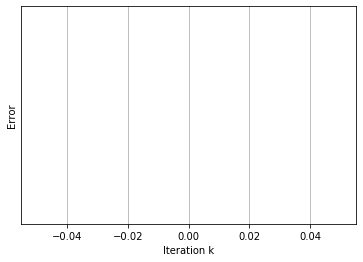

In [67]:
plt.xlabel("Iteration k")
plt.yscale('symlog')
plt.ylabel("Error")
plt.plot(np.mean(errors, axis=0))
plt.grid(which='major')
plt.grid(which='minor')
plt.savefig("../out/plots/MNIST_PRCGAN_error-{}-{}s-{}b.png".format(model_name, steps, num_batches), dpi=200)
plt.show()

In [68]:
### CACHE RESULTS ###

import pickle
pickle.dump(out_original, open("../cache/prcgan/prcgan-{}-{}s-{}b_original.p".format(model_name, steps, num_batches), "wb"))
pickle.dump(out_results, open("../cache/prcgan/prcgan-{}-{}s-{}b.p".format(model_name, steps, num_batches), "wb"))

In [69]:
### LOAD RESULTS ###
import pickle

out_original = pickle.load(open("../cache/prcgan/prcgan-{}-{}s-{}b_original.p".format(model_name, steps, num_batches), "rb"))
out_results = pickle.load(open("../cache/prcgan/prcgan-{}-{}s-{}b.p".format(model_name, steps, num_batches), "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


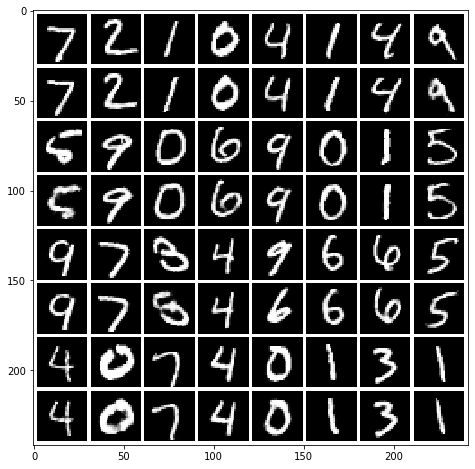

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Registered:


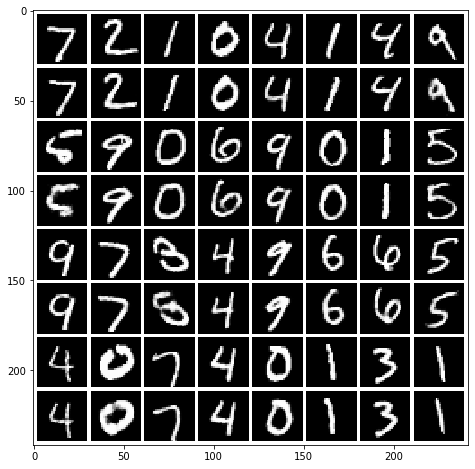

In [70]:
# Print predictions #
to_plot = np.stack([out_original[:32, 0].reshape(4, 8, 28, 28), 
                    out_results[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
plot_grid(to_plot, figsize=(8,8),file="../out/MNIST/generative-prior/prcgan-{}-{}s-{}b.png"\
          .format(model_name, steps, num_batches))

print("Registered:")
results_reg = register_croco(out_results[:32], out_original[:32])
to_plot = np.stack([out_original[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)        
plot_grid(to_plot, figsize=(8,8), file="../out/MNIST/generative-prior/prcgan-{}-{}s-{}b-reg.png"\
          .format(model_name, steps, num_batches))

In [71]:
# Benchmark test predictions #

benchmark(pred=out_results[:1024], true=out_original[:1024], check_all=True)

Signal error:
  MSE: 0.022475281660234107, std: 0.02173761420933473
  MAE: 0.04585451915513217, std: 0.02774277372489171
  SSIM: 0.815867531589457, std: 0.14620040646063784
  Sharpness: 0.08312081788594738, std: 0.02798763602995287
  PhCo-MSE: 0.015099398268568496, std: 0.011299904472760743
  PhCo-MAE: 0.03677124958961847, std: 0.016852073448319682
  PhCo-SSIM: 0.8643893244302768, std: 0.08595353535009348
  CroCo-MSE: 0.013668608773294176, std: 0.008167097607948067
  CroCo-MAE: 0.03501169157996736, std: 0.0143238805379362
  CroCo-SSIM: 0.8743942705933785, std: 0.06897131884598529

Magnitude error:
  MSE Magnitude: 2.4263552154146613, std: 1.6312522642587095

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.02248 | 0.04585 | 0.8159 | 0.08312 | 0.01510 | 0.03677 | 0.8644 | 0.01367 | 0.03501 | 0.8744 | 2.426 |


### Random z

| steps | lr | reg | MSE | MAE | SSIM | SHRP | PhCo-MSE | PhCo-MAE | PhCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 100 | 1.0 | - | 0.02037 | 0.03864 | 0.8427 | 0.03576 | 0.003203 | 0.01405 | 0.9685 | 0.002880 | 0.01365 | 0.9708 | 0.2468 |
| 1000 | 1.0 | - | 0.02103 | 0.03678 | 0.8408 | 0.01654 | 0.001453 | 0.006769 | 0.9858 | 0.001251 | 0.006517 | 0.9873 | 0.06303 |
| 10000 | 1.0 | - | 0.02113 | 0.03600 | 0.8400 | 0.01105 | 0.001326 | 0.004837 | 0.9874 | 0.001113 | 0.004595 | 0.9888 | 0.03529 |

Signal error:
  MSE: 0.021034426705518874, std: 0.02792752544231687
  MAE: 0.036783379523503315, std: 0.03980707234886323
  SSIM: 0.8407555464867762, std: 0.19330732876058487
  Sharpness: 0.016542975558316922, std: 0.020552354326638336
  PhCo-MSE: 0.001453431413425473, std: 0.0057620394486133835
  PhCo-MAE: 0.006769362872673511, std: 0.010701422534126185
  PhCo-SSIM: 0.9858415777938948, std: 0.04926352788838103
  CroCo-MSE: 0.0012506157955389642, std: 0.004712075279271575
  CroCo-MAE: 0.006516509510403279, std: 0.009707250524531892
  CroCo-SSIM: 0.9872627592984858, std: 0.042788646500661026

Magnitude error:
  MSE Magnitude: 0.06302549643392931, std: 0.16088016570130523

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]


---

Signal error:
  MSE: 0.021132170758821553, std: 0.027943211615490165
  MAE: 0.03600185587283779, std: 0.04061892559390817
  SSIM: 0.8399740670455008, std: 0.19436162986255717
  Sharpness: 0.011045982589995972, std: 0.022084064040708763
  PhCo-MSE: 0.0013261830257157393, std: 0.006281207836805215
  PhCo-MAE: 0.004837244000750465, std: 0.011444139637821652
  PhCo-SSIM: 0.9873820491788762, std: 0.05257601658001079
  CroCo-MSE: 0.0011132030792846343, std: 0.005047995534352116
  CroCo-MAE: 0.004595263382659135, std: 0.010414105816178337
  CroCo-SSIM: 0.9887715130018514, std: 0.046605838235418105

Magnitude error:
  MSE Magnitude: 0.035290605860936894, std: 0.13599231279468096

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]
  
  
### z = magn

| steps | lr | reg | MSE | MAE | SSIM | SHRP | PhCo-MSE | PhCo-MAE | PhCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 10000 | 1.0 | - | 0.02387 | 0.04008 | 0.8220 | 0.01203 | 0.001308 | 0.005192 | 0.9880 | 0.001128 | 0.004981 | 0.9890 | 0.04126 |

Signal error:
  MSE: 0.023872316614280326, std: 0.02985488824086263
  MAE: 0.04007831752331549, std: 0.04222464722715452
  SSIM: 0.82200604264092, std: 0.2018574279793221
  Sharpness: 0.012030273327434449, std: 0.02156160638071391
  PhCo-MSE: 0.001307936574175579, std: 0.00611107212154575
  PhCo-MAE: 0.0051915426976917286, std: 0.011252478383608865
  PhCo-SSIM: 0.9879541935080723, std: 0.05152743484919095
  CroCo-MSE: 0.00112786660608192, std: 0.005091916801362864
  CroCo-MAE: 0.0049812968493204894, std: 0.010281700172205668
  CroCo-SSIM: 0.9890283994416267, std: 0.04654741252853095

Magnitude error:
  MSE Magnitude: 0.04126474308762697, std: 0.1309130277274746

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]


### z = 0

| steps | lr | reg | MSE | MAE | SSIM | SHRP | PhCo-MSE | PhCo-MAE | PhCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 0.1 | - | 0.02248 | 0.04585 | 0.8159 | 0.08312 | 0.01510 | 0.03677 | 0.8644 | 0.01367 | 0.03501 | 0.8744 | 2.426 |
| 10 | 0.1 | - | 0.02064 | 0.04201 | 0.8359 | 0.06459 | 0.008601 | 0.02649 | 0.9185 | 0.007943 | 0.02567 | 0.9231 | 1.037 |
| 25 | 0.1 | - | 0.01996 | 0.04010 | 0.8436 | 0.05315 | 0.005910 | 0.02125 | 0.9429 | 0.005443 | 0.02068 | 0.9463 | 0.5937 |
| 100 | 0.1 | - | 0.02012 | 0.03797 | 0.8460 | 0.03455 | 0.002995 | 0.01350 | 0.9707 | 0.002712 | 0.01316 | 0.9730 | 0.2225 |
| 500 | 0.1 | - | 0.02057 | 0.03642 | 0.8444 | 0.01956 | 0.001560 | 0.007792 | 0.9846 | 0.001353 | 0.007543 | 0.9862 | 0.07636 |
| 1000 | 0.1 | - | 0.02072 | 0.03604 | 0.8438 | 0.01598 | 0.001328 | 0.006466 | 0.9869 | 0.001136 | 0.006245 | 0.9883 | 0.05313 |
| 2000 | 0.1 | - | 0.02084 | 0.03578 | 0.8433 | 0.01334 | 0.001183 | 0.005510 | 0.9884 | 0.001013 | 0.005307 | 0.9897 | 0.04027 |
| 4000 | 0.1 | - | 0.02093 | 0.03563 | 0.8428 | 0.01148 | 0.001055 | 0.004806 | 0.9894 | 0.0009179 | 0.004637 | 0.9905 | 0.03272 |
| 10000 | 1.0 | - | 0.02102 | 0.03548 | 0.8423 | 0.009946 | 0.001011 | 0.004255 | 0.9898 | 0.0008475 | 0.004057 | 0.9911 | 0.02658 |


Signal error:
  MSE: 0.021019180475365603, std: 0.02893437074694003
  MAE: 0.0354793687128571, std: 0.04125123341771097
  SSIM: 0.8422982977483061, std: 0.19752906093002276
  Sharpness: 0.009946102982066591, std: 0.01921682279750895
  PhCo-MSE: 0.0010112216698962948, std: 0.004696567460229517
  PhCo-MAE: 0.004255040753619008, std: 0.009488312333523525
  PhCo-SSIM: 0.9898329175272272, std: 0.04207521855964034
  CroCo-MSE: 0.0008474868159656598, std: 0.003538177245859828
  CroCo-MAE: 0.004056901976908469, std: 0.00850613337291144
  CroCo-SSIM: 0.9910881100390998, std: 0.035361086317214394

Magnitude error:
  MSE Magnitude: 0.026575725753501103, std: 0.0879305049935527

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

## Out of distribution

In [22]:
# Helper functions

from PIL import Image

def unit(x, scale=1):
    _x = x ** scale
    _x = _x - np.minimum(np.min(_x), 0)
    return _x / np.max(_x)

def plot(x):
    plt.imshow(x, cmap="gray")
    plt.show()

def save_array(array, path):
    array = np.clip(array, 0.0, 1.0)
    plot(array)
    im = Image.fromarray((255 * array).astype('uint8'))
    im.save(path)

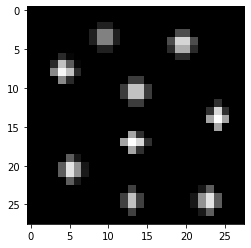

In [23]:
from skimage import io

name = "ood4"

ood_x = torch.tensor(io.imread('../data/ood/{}.png'.format(name), as_gray=True),
                    dtype = next(iter(dataloader['train'])).dtype)[None, None, ...]

plot(ood_x[0, 0])

In [46]:
### Latent z optimization ###

steps = 20000
lmd = 0.0
lr = 1e-1

###

test_sample = ood_x.to(device)
test_magnitudes = calc_mags(test_sample)

z = torch.zeros(*test_magnitudes.shape, dtype=test_magnitudes.dtype, device=device).to(device)
out_prcgan = gen(torch.cat([z, test_magnitudes], dim=1)).cpu().detach().numpy()

out_results, error = genopt(sample_magn=test_magnitudes, gen=gen,
                                    device=device, steps=steps, lmd=lmd, lr=lr)

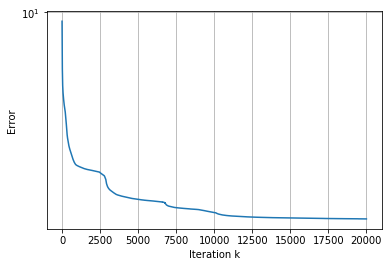

In [47]:
plt.xlabel("Iteration k")
plt.yscale('symlog')
plt.ylabel("Error")
plt.plot(np.concatenate(error))
plt.grid(which='major')
plt.grid(which='minor')
plt.show()

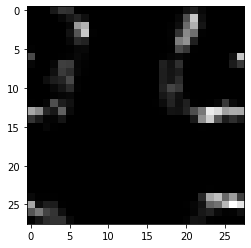

In [42]:
prcgagn_reg = register_croco(out_prcgan, ood_x.numpy())[0, 0]
plot(prcgagn_reg)
#save_array(prcgagn_reg, "../out/ood/PRCGAN_{}.png".format(name))

In [134]:
# Benchmark test predictions #

benchmark(pred=out_prcgan, true=ood_x, check_all=True)

Signal error:
  MSE: 0.045084577053785324, std: 0.0
  MAE: 0.08697747439146042, std: 0.0
  SSIM: -0.006674177139372506, std: 0.0
  Sharpness: 0.11858339168613204, std: 0.0
  PhCo-MSE: 0.03285229951143265, std: 0.0
  PhCo-MAE: 0.06943946331739426, std: 0.0
  PhCo-SSIM: 0.2816141408631426, std: 0.0
  CroCo-MSE: 0.03275955095887184, std: 0.0
  CroCo-MAE: 0.07045449316501617, std: 0.0
  CroCo-SSIM: 0.23259667517318142, std: 0.0

Magnitude error:
  MSE Magnitude: 9.2093947577962, std: 0.0

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 0.90] - should be in [0, 1]

Markdown table values:
 0.04508 | 0.08698 | -0.006674 | 0.1186 | 0.03285 | 0.06944 | 0.2816 | 0.03276 | 0.07045 | 0.2326 | 9.209 |


| Image | MSE | MAE | SSIM | SHRP | PhCo-MSE | PhCo-MAE | PhCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| ood1 | 0.09158 | 0.1270 | 0.3418 | 0.1914 | 0.08055 | 0.1148 | 0.3984 | 0.08055 | 0.1148 | 0.3984 | 32.06 |
| ood2 | 0.07913 | 0.1442 | 0.5772 | 0.2450 | 0.07508 | 0.1433 | 0.6317 | 0.07262 | 0.1392 | 0.6327 | 18.15 |
| ood3 | 0.05630 | 0.1214 | 0.5215 | 0.1564 | 0.08111 | 0.1586 | 0.3080 | 0.05396 | 0.1203 | 0.5327 | 17.29 |
| ood4 |  0.04508 | 0.08698 | -0.006674 | 0.1186 | 0.03285 | 0.06944 | 0.2816 | 0.03276 | 0.07045 | 0.2326 | 9.209 |

Signal error:
  MSE: 0.09158428013324738, std: 0.0
  MAE: 0.12704087793827057, std: 0.0
  SSIM: 0.3417771759587241, std: 0.0
  Sharpness: 0.19137920755130375, std: 0.0
  PhCo-MSE: 0.08054737746715546, std: 0.0
  PhCo-MAE: 0.11476302891969681, std: 0.0
  PhCo-SSIM: 0.3983675382502317, std: 0.0
  CroCo-MSE: 0.08054737746715546, std: 0.0
  CroCo-MAE: 0.11476302891969681, std: 0.0
  CroCo-SSIM: 0.3983675382502317, std: 0.0

Magnitude error:
  MSE Magnitude: 32.06141858344275, std: 0.0

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]
  
---

Signal error:
  MSE: 0.07912658900022507, std: 0.0
  MAE: 0.14415504038333893, std: 0.0
  SSIM: 0.5772419136738425, std: 0.0
  Sharpness: 0.24499511395505566, std: 0.0
  PhCo-MSE: 0.07508289813995361, std: 0.0
  PhCo-MAE: 0.1433252990245819, std: 0.0
  PhCo-SSIM: 0.6316906438645042, std: 0.0
  CroCo-MSE: 0.07261687517166138, std: 0.0
  CroCo-MAE: 0.13921010494232178, std: 0.0
  CroCo-SSIM: 0.6327277807571422, std: 0.0

Magnitude error:
  MSE Magnitude: 18.14830286229828, std: 0.0

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

---

Signal error:
  MSE: 0.05630173161625862, std: 0.0
  MAE: 0.12144176661968231, std: 0.0
  SSIM: 0.5215032806234714, std: 0.0
  Sharpness: 0.15640147832142867, std: 0.0
  PhCo-MSE: 0.08111244440078735, std: 0.0
  PhCo-MAE: 0.15859831869602203, std: 0.0
  PhCo-SSIM: 0.3080341669464391, std: 0.0
  CroCo-MSE: 0.05396179109811783, std: 0.0
  CroCo-MAE: 0.12031954526901245, std: 0.0
  CroCo-SSIM: 0.5326721175853248, std: 0.0

Magnitude error:
  MSE Magnitude: 17.290702087269636, std: 0.0

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]
  
---

Signal error:
  MSE: 0.045084577053785324, std: 0.0
  MAE: 0.08697747439146042, std: 0.0
  SSIM: -0.006674177139372506, std: 0.0
  Sharpness: 0.11858339168613204, std: 0.0
  PhCo-MSE: 0.03285229951143265, std: 0.0
  PhCo-MAE: 0.06943946331739426, std: 0.0
  PhCo-SSIM: 0.2816141408631426, std: 0.0
  CroCo-MSE: 0.03275955095887184, std: 0.0
  CroCo-MAE: 0.07045449316501617, std: 0.0
  CroCo-SSIM: 0.23259667517318142, std: 0.0

Magnitude error:
  MSE Magnitude: 9.2093947577962, std: 0.0

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 0.90] - should be in [0, 1]

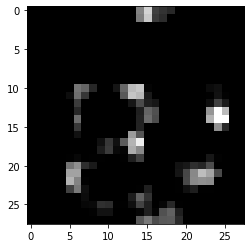

In [48]:
out_reg = register_croco(out_results, ood_x.numpy())[0, 0]
plot(out_reg)
#save_array(out_reg, "../out/ood/PRCGANstar_{}.png".format(name))

In [49]:
# Benchmark test predictions #

benchmark(pred=out_results, true=ood_x, check_all=True)

Signal error:
  MSE: 0.04986915737390518, std: 0.0
  MAE: 0.09154187142848969, std: 0.0
  SSIM: 0.031055653534716666, std: 0.0
  Sharpness: 0.10804084272036908, std: 0.0
  PhCo-MSE: 0.02642538584768772, std: 0.0
  PhCo-MAE: 0.06128409504890442, std: 0.0
  PhCo-SSIM: 0.4054515975246602, std: 0.0
  CroCo-MSE: 0.02642538584768772, std: 0.0
  CroCo-MAE: 0.06128409504890442, std: 0.0
  CroCo-SSIM: 0.4054515975246602, std: 0.0

Magnitude error:
  MSE Magnitude: 1.7442256536763008, std: 0.0

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.04987 | 0.09154 | 0.03106 | 0.1080 | 0.02643 | 0.06128 | 0.4055 | 0.02643 | 0.06128 | 0.4055 | 1.744 |


### Results

| Image | MSE | MAE | SSIM | SHRP | PhCo-MSE | PhCo-MAE | PhCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| ood1 | 0.02770 | 0.05315 | 0.7710 | 0.004960 | 0.00004218 | 0.001765 | 0.9996 | 0.00004218 | 0.001765 | 0.9996 | 0.005852 |
| ood2 | 0.02419 | 0.07750 | 0.8736 | 0.1487 | 0.03457 | 0.09206 | 0.8130 | 0.02419 | 0.07750 | 0.8736 | 0.4336 |
| ood3 | 0.04484 | 0.1074 | 0.5207 | 0.1261 | 0.06887 | 0.1467 | 0.3723 | 0.03361 | 0.08982 | 0.6314 | 2.414 |
| ood4 | 0.04934 | 0.09020 | 0.05541 | 0.1093 | 0.02609 | 0.06047 | 0.4318 | 0.02609 | 0.06047 | 0.4318 | 1.864 |


Signal error:
  MSE: 0.027697743847966194, std: 0.0
  MAE: 0.05315403640270233, std: 0.0
  SSIM: 0.7710268015092463, std: 0.0
  Sharpness: 0.004959979565729783, std: 0.0
  PhCo-MSE: 4.2183772166026756e-05, std: 0.0
  PhCo-MAE: 0.0017646298510953784, std: 0.0
  PhCo-SSIM: 0.9995681978333341, std: 0.0
  CroCo-MSE: 4.2183772166026756e-05, std: 0.0
  CroCo-MAE: 0.0017646298510953784, std: 0.0
  CroCo-SSIM: 0.9995681978333341, std: 0.0

Magnitude error:
  MSE Magnitude: 0.005852027203089378, std: 0.0

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

---

  Signal error:
  MSE: 0.024187613278627396, std: 0.0
  MAE: 0.07749766856431961, std: 0.0
  SSIM: 0.8735559622970296, std: 0.0
  Sharpness: 0.1487014282076018, std: 0.0
  PhCo-MSE: 0.03456888720393181, std: 0.0
  PhCo-MAE: 0.09205664694309235, std: 0.0
  PhCo-SSIM: 0.8130491524050628, std: 0.0
  CroCo-MSE: 0.024187613278627396, std: 0.0
  CroCo-MAE: 0.07749766856431961, std: 0.0
  CroCo-SSIM: 0.8735559622970296, std: 0.0

Magnitude error:
  MSE Magnitude: 0.43362352480209276, std: 0.0

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]
  
---

Signal error:
  MSE: 0.04484163597226143, std: 0.0
  MAE: 0.1074015200138092, std: 0.0
  SSIM: 0.5206979924800422, std: 0.0
  Sharpness: 0.1260864548932636, std: 0.0
  PhCo-MSE: 0.06886935234069824, std: 0.0
  PhCo-MAE: 0.14671902358531952, std: 0.0
  PhCo-SSIM: 0.3723139753063939, std: 0.0
  CroCo-MSE: 0.03361382335424423, std: 0.0
  CroCo-MAE: 0.08982023596763611, std: 0.0
  CroCo-SSIM: 0.6313522289718954, std: 0.0

Magnitude error:
  MSE Magnitude: 2.413656301347703, std: 0.0

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 0.98] - should be in [0, 1]

---

Signal error:
  MSE: 0.04934088885784149, std: 0.0
  MAE: 0.09019559621810913, std: 0.0
  SSIM: 0.05540975593995, std: 0.0
  Sharpness: 0.1093139537477712, std: 0.0
  PhCo-MSE: 0.026087353006005287, std: 0.0
  PhCo-MAE: 0.060470100492239, std: 0.0
  PhCo-SSIM: 0.43175640745445765, std: 0.0
  CroCo-MSE: 0.026087353006005287, std: 0.0
  CroCo-MAE: 0.060470100492239, std: 0.0
  CroCo-SSIM: 0.43175640745445765, std: 0.0

Magnitude error:
  MSE Magnitude: 1.8636795783463138, std: 0.0

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]